In [49]:
# Import helps
from src.helpers import *
from src.plots import *

# Import base
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split

# Feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP
from sklearn.pipeline import Pipeline

# tensorflow
import tensorflow as tf

pd.options.display.max_rows = 999

# Set seeds for reproducibility
set_seeds()

In [50]:
# class weight function
def cwts(y):
    c0, c1 = np.bincount(y)
    w0=(1/c0)*(len(y))/2 
    w1=(1/c1)*(len(y))/2 
    return {0: w0, 1: w1}

In [51]:
weights = {0: 0.5942162615255658, 1: 3.15346975088968}

In [52]:
tf.keras.backend.clear_session()

In [53]:
# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv', parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv', parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv', parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv', parse_dates=True, index_col='unix')
X_val = pd.read_csv('data/val/scaled_X_val.csv', parse_dates=True, index_col='unix')
y_val = pd.read_csv('data/val/y_val.csv', parse_dates=True, index_col='unix')

In [54]:
y = pd.concat([y_train, y_val, y_test])
y.values.flatten()
weights = cwts(y.values.flatten())

In [55]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=weights)
vif = VIFTransform()
boruta = BorutaPy(rf, n_estimators='auto', verbose=2)
umap = UMAP(n_neighbors=5)
pipe_1 = Pipeline([('boruta', boruta), ('umap', umap)], verbose=True)

In [56]:
X_train = pipe_1.fit_transform(X_train.values, y_train.values.ravel())
X_val = pipe_1.transform(X_val.values)
X_test = pipe_1.transform(X_test.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	366
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	348
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	15
Rejected: 	348
Iteration: 	16 / 100
Confirmed: 	4
Tentat

In [57]:
# Reshape the data into the correct format
seqlen = 1
featurelen = X_train.shape[-1]
train_tensors = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(X_val, y_val, seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, seqlen)

In [58]:
# Baseline model
inputs = tf.keras.Input(shape=(seqlen, featurelen))
x = tf.keras.layers.LSTM(36)(inputs)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [59]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 36)                5616      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5653 (22.08 KB)
Trainable params: 5653 (22.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5)]

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(x=train_tensors, epochs=100, validation_data=val_tensors,
                    class_weight=weights, callbacks=callbacks)

Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 0.7453 - accuracy: 0.5910 - precision: 0.3142 - recall: 0.7541 - val_loss: 0.6074 - val_accuracy: 0.7633 - val_precision: 0.2200 - val_recall: 0.4698
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.6194 - precision: 0.3352 - recall: 0.7738 - val_loss: 0.5698 - val_accuracy: 0.7851 - val_precision: 0.2328 - val_recall: 0.4326
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6382 - precision: 0.3480 - recall: 0.7711 - val_loss: 0.5543 - val_accuracy: 0.7906 - val_precision: 0.2353 - val_recall: 0.4186
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6486 - precision: 0.3550 - recall: 0.7657 - val_loss: 0.5485 - val_accuracy: 0.7964 - val_precision: 0.2317 - val_recall: 0.3837
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.6545 - precisi

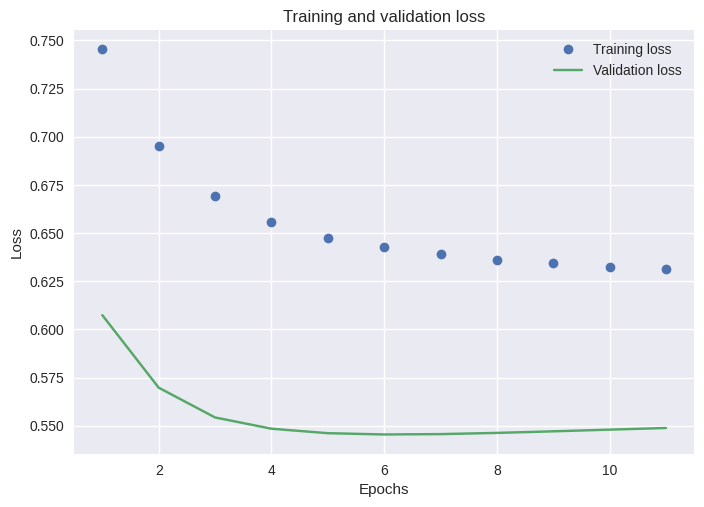

In [61]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plot_metrics(loss_values, val_loss_values, 'loss')

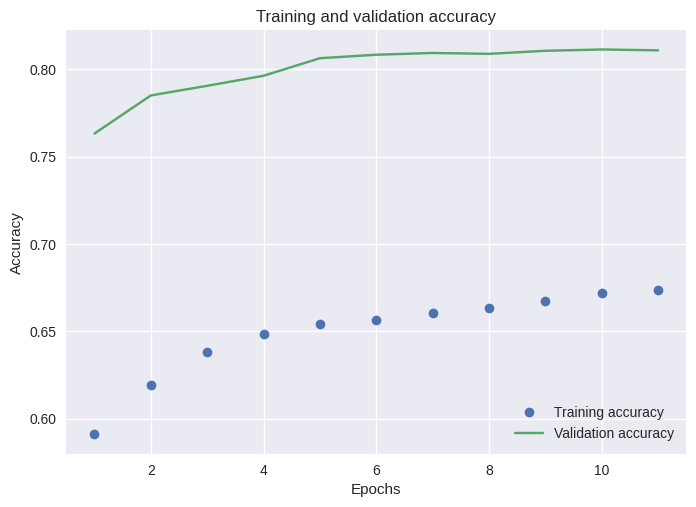

In [62]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
plot_metrics(accuracy_values, val_accuracy_values, 'accuracy')

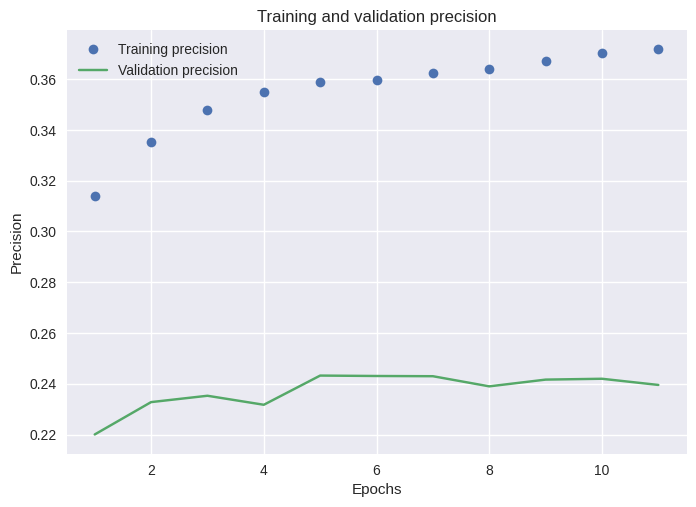

In [63]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
plot_metrics(precision_values, val_precision_values, 'precision')

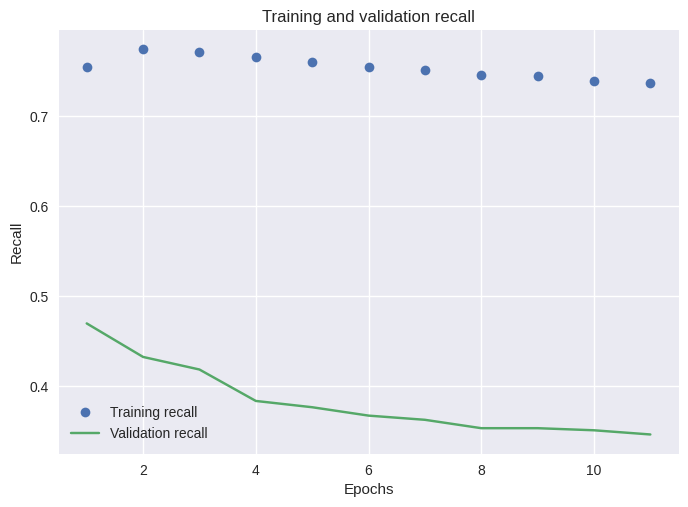

In [64]:
recall_values = history_dict['recall']
val_recall_values = history_dict['val_recall']
plot_metrics(recall_values, val_recall_values, 'recall')

In [65]:
y_pred = np.where(model.predict(test_tensors) > 0.5, 1, 0)

42/42 [==============================] - 0s 1ms/step


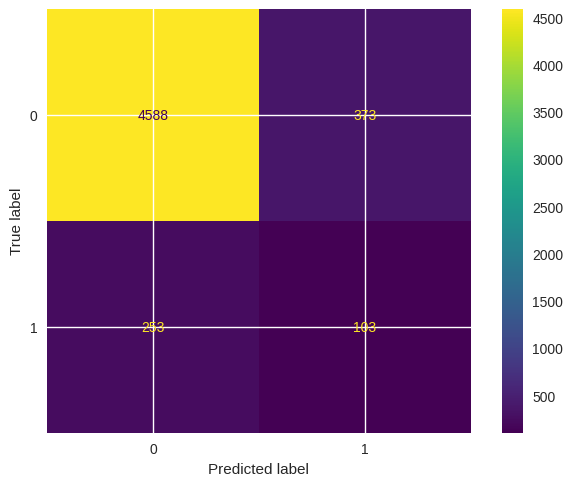

In [66]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

cm = confusion_matrix(y_test.values, y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

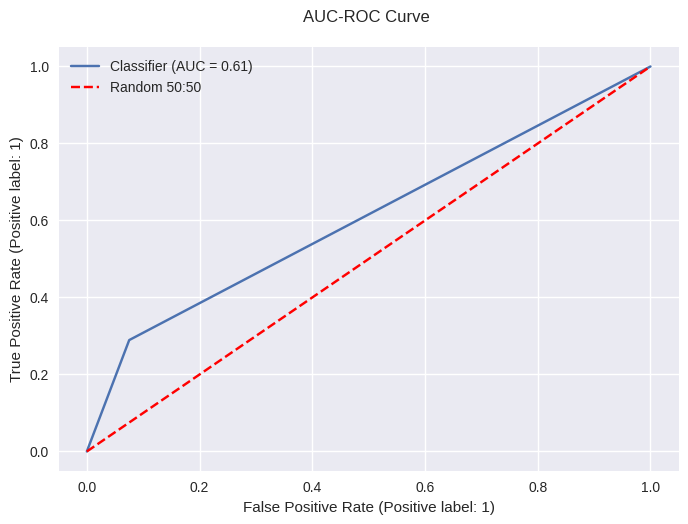

In [67]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='r')
plt.legend()
plt.show()

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4961
           1       0.22      0.29      0.25       356

    accuracy                           0.88      5317
   macro avg       0.58      0.61      0.59      5317
weighted avg       0.90      0.88      0.89      5317

